In [ ]:
!nvidia-smi

Thu Apr  8 15:02:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install patchify 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from PlotSeis import PlotSeis
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from patchify import patchify, unpatchify

In [ ]:
clean_signal_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/cs.npy')
noise_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/n.npy')
noisy_signal_HF = np.load('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/data/synth/ns.npy')



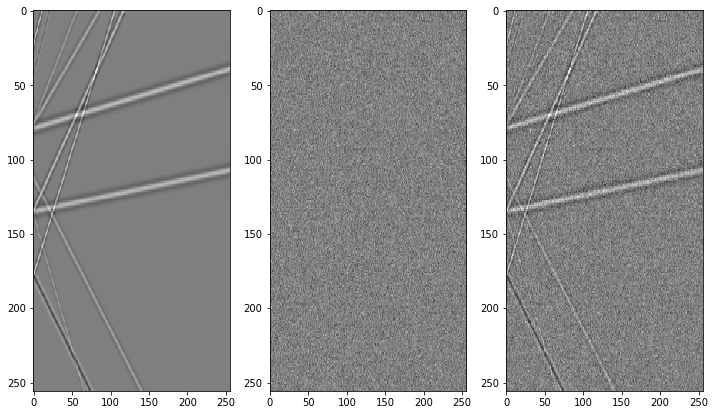

In [ ]:
PlotSeis([clean_signal_HF,noise_HF,noisy_signal_HF],num=163)

In [ ]:
psnr = []
num_img=600
for i in range(num_img):
    psnr.append(PSNR(clean_signal_HF[i],noisy_signal_HF[i]))
print(np.min(psnr),np.max(psnr))

11.064474551256712 33.46251626927184


In [ ]:
# Generating training and testing data
# NS_train_wind, NS_test_wind, S_train_wind, S_test_wind = train_test_split(ns_windows,cs_windows, test_size=0.33, random_state = 21)
NS_train, NS_test, S_train, S_test = train_test_split(noisy_signal_HF,clean_signal_HF, test_size=0.33, random_state = 21)

# NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv_sc,cs_windows_conv_sc, test_size=0.33, random_state = 21)
# NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv,cs_windows_conv, test_size=0.33, random_state = 21)

In [ ]:
del noisy_signal_HF,clean_signal_HF,noise_HF

In [ ]:
# Extracting non-overlapping windows
def prep_windows(data,w,):
  windows = []
  
  for iImg in range(data.shape[0]):
    windows.append(img2windows(data[iImg,:,:,0],w,w))

  windows = np.array(windows)
  windows_resh = tf.convert_to_tensor(windows.reshape(windows.shape[0]*windows.shape[1],w,w,1))
  return windows,windows_resh

In [ ]:
NS_train_conv_ovlp_w32 = []
S_train_conv_ovlp_w32 = []
NS_test_conv_ovlp_w32 = []
S_test_conv_ovlp_w32 = []


for i in range(NS_train.shape[0]):
  NS_train_conv_ovlp_w32.append(patchify(NS_train[i,:,:,0],(32,32),(16,16)))
  S_train_conv_ovlp_w32.append(patchify(S_train[i,:,:,0],(32,32),(16,16)))

for i in range(NS_test.shape[0]):
  NS_test_conv_ovlp_w32.append(patchify(NS_test[i,:,:,0],(32,32),(16,16)))
  S_test_conv_ovlp_w32.append(patchify(S_test[i,:,:,0],(32,32),(16,16)))

NS_train_conv_ovlp_w32 = np.array(NS_train_conv_ovlp_w32)
S_train_conv_ovlp_w32 = np.array(S_train_conv_ovlp_w32)
NS_test_conv_ovlp_w32 = np.array(NS_test_conv_ovlp_w32)
S_test_conv_ovlp_w32 = np.array(S_test_conv_ovlp_w32)

a,b,c,d,e = NS_train_conv_ovlp_w32.shape
f,g,h,i,j = NS_test_conv_ovlp_w32.shape

NS_train_conv_ovlp_resh_w32 = tf.convert_to_tensor(NS_train_conv_ovlp_w32.reshape(a*b*c,d,e,1))
S_train_conv_ovlp_resh_w32 = tf.convert_to_tensor(S_train_conv_ovlp_w32.reshape(a*b*c,d,e,1))
NS_test_conv_ovlp_resh_w32 = tf.convert_to_tensor(NS_test_conv_ovlp_w32.reshape(f*g*h,i,j,1))
S_test_conv_ovlp_resh_w32 = tf.convert_to_tensor(S_test_conv_ovlp_w32.reshape(f*g*h,i,j,1))

In [ ]:
w=32
NS_train_conv_w32, NS_train_conv_resh_w32 = prep_windows(NS_train,w=w)
NS_test_conv_w32, NS_test_conv_resh_w32 = prep_windows(NS_test,w=w)
S_train_conv_w32, S_train_conv_resh_w32 = prep_windows(S_train,w=w)
S_test_conv_w32, S_test_conv_resh_w32 = prep_windows(S_test,w=w)
# w=64
# NS_train_conv_w64, NS_train_conv_resh_w64 = prep_windows(NS_train,w=w)
# NS_test_conv_w64, NS_test_conv_resh_w64 = prep_windows(NS_test,w=w)
# S_train_conv_w64, S_train_conv_resh_w64 = prep_windows(S_train,w=w)
# S_test_conv_w64, S_test_conv_resh_w64 = prep_windows(S_test,w=w)
# w=128
# NS_train_conv_w128, NS_train_conv_resh_w128 = prep_windows(NS_train,w=w)
# NS_test_conv_w128, NS_test_conv_resh_w128 = prep_windows(NS_test,w=w)
# S_train_conv_w128, S_train_conv_resh_w128 = prep_windows(S_train,w=w)
# S_test_conv_w128, S_test_conv_resh_w128 = prep_windows(S_test,w=w)
# w=256
# NS_train_conv_w256, NS_train_conv_resh_w256 = prep_windows(NS_train,w=w)
# NS_test_conv_w256, NS_test_conv_resh_w256 = prep_windows(NS_test,w=w)
# S_train_conv_w256, S_train_conv_resh_w256 = prep_windows(S_train,w=w)
# S_test_conv_w256, S_test_conv_resh_w256 = prep_windows(S_test,w=w)

In [ ]:
def pad(data, win_size):
  padded_data = []
  half = int(win_size/2)
  paddings = tf.constant([[half,half,], [half,half]],dtype=tf.int32)
  for i in range(data.shape[0]):
    temp = tf.pad(tf.reshape(data[i],(win_size,win_size)),paddings,mode='REFLECT')
    padded_data.append(tf.reshape(temp,(win_size*2, win_size*2,1)))

  return tf.convert_to_tensor(np.array(padded_data))
    

In [ ]:
# w=32
# NS_train_conv_w32_ovlp, NS_train_conv_resh_w32_ovlp = prep_windows_ovlp(NS_train,w=int(w))
# # NS_test_conv_w32, NS_test_conv_resh_w32 = prep_windows_ovlp(NS_test,w=w)
# # S_train_conv_w32, S_train_conv_resh_w32 = prep_windows_ovlp(S_train,w=w)
# # S_test_conv_w32, S_test_conv_resh_w32 = prep_windows_ovlp(S_test,w=w)

In [ ]:
# # Creating models

# # modelConv3x3 = autoencoder("upsc",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConv3x3_v2 = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConv3x3_SGD = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConv3x3_v2_HF = autoencoder("upsc_v2",kernel=(3,3),input_size=(win_size,win_size,1))

# # modelConvUnet = autoencoder("Unet_NoSc",kernel=(3,3),input_size=(win_size,win_size,1))
# modelConvUnet_v2 = autoencoder("Unet_NoSc_v2",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConvUnet_v3_SGD = autoencoder("Unet_NoSc_v3",kernel=(3,3),input_size=(win_size,win_size,1))
# # modelConvUnet_v2_SGD = autoencoder("Unet_NoSc_v2",kernel=(3,3),input_size=(win_size,win_size,1))

# modelANN_trc = autoencoder("ANN")

# ANN_trc = autoencoder("ANN")
# Conv3x3 = autoencoder("upsc_v2",kernel=(3,3),input_size=(32,32,1))
# Conv3x3_w64 = autoencoder("upsc_v2",kernel=(3,3),input_size=(64,64,1))
# Conv3x3_w128 = autoencoder("upsc_v2",kernel=(3,3),input_size=(128,128,1))
# Conv3x3_w256 = autoencoder("upsc_v2",kernel=(3,3),input_size=(256,256,1))

# Conv3x3_w32_avg = autoencoder("upsc_v2_avg",kernel=(3,3),input_size=(32,32,1))
# Conv3x3_w64_avg = autoencoder("upsc_v2_avg",kernel=(3,3),input_size=(64,64,1))
# Conv3x3_w128_avg = autoencoder("upsc_v2_avg",kernel=(3,3),input_size=(128,128,1))
# Conv3x3_w256_avg = autoencoder("upsc_v2_avg",kernel=(3,3),input_size=(256,256,1))

Conv3x3_w32_ovlp = autoencoder("upsc_v2",kernel=(3,3),input_size=(32,32,1))

Conv3x3_w32_v2 = autoencoder("upsc_v2",kernel=(3,3),input_size=(None,None,1))

Unet = autoencoder('Unet_v3',kernel=(3,3),input_size=(None,None,1))

# Conv3x3_w32_pad = autoencoder("upsc_v2",kernel=(3,3),input_size=(64,64,1))


# Unet = autoencoder("Unet_v3",kernel=(3,3),input_size=(32,32,1))

In [ ]:
# # Compiling models
# sgd = Adam(lr=0.001)
# # modelConv3x3.compile(loss='mse',optimizer='adam')
# # modelConv3x3_v2.compile(loss='mse',optimizer='adam')
# # modelConv3x3_SGD.compile(loss='mse',optimizer=sgd)
# modelConv3x3_v2_HF.compile(loss='mse',optimizer='adam')
# modelConv3x3_v2_dr_HF.compile(loss='mse',optimizer='adam')

# # modelConvUnet.compile(loss='mse',optimizer='adam')
# modelConvUnet_v2.compile(loss='mse',optimizer='adam')
# # modelConvUnet_v2_SGD.compile(loss='mse',optimizer=sgd)
# # modelConvUnet_v3_SGD.compile(loss='mse',optimizer=sgd)

# modelANN_trc.compile(loss='mse',optimizer='adam')
# # modelANN_trc_SGD.compile(loss='mse',optimizer=sgd)

# ANN_trc.compile(loss='mse',optimizer='adam')
# Conv3x3.compile(loss='mse',optimizer='adam')
# Conv3x3_w64.compile(loss='mse',optimizer='adam')
# Conv3x3_w128.compile(loss='mse',optimizer='adam')
# Conv3x3_w256.compile(loss='mse',optimizer='adam')

# Conv3x3_w32_avg.compile(loss='mse',optimizer='adam')
# Conv3x3_w64_avg.compile(loss='mse',optimizer='adam')
# Conv3x3_w128_avg.compile(loss='mse',optimizer='adam')
# Conv3x3_w256_avg.compile(loss='mse',optimizer='adam')

# Conv3x3_w32_ovlp.compile(loss='mse',optimizer='adam')
# Conv3x3_w32_pad.compile(loss='mse',optimizer='adam')

Conv3x3_w32_v2.compile(loss='mse',optimizer='adam')

Unet.compile(loss='mse',optimizer='adam')

# Unet.compile(loss='mse',optimizer='adam')

In [ ]:
# Creating callback for training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0005,
    patience=30,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
batch_size= 256
epochs = 200
Unet_hist = Unet.fit(NS_train_conv_resh_w32, S_train_conv_resh_w32, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_w32,S_test_conv_resh_w32),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/200
101/101 [==============================] - 9s 56ms/step - loss: 0.3945 - val_loss: 0.0625
Epoch 2/200
101/101 [==============================] - 4s 44ms/step - loss: 0.0322 - val_loss: 0.0489
Epoch 3/200
101/101 [==============================] - 4s 44ms/step - loss: 0.0249 - val_loss: 0.0321
Epoch 4/200
101/101 [==============================] - 5s 45ms/step - loss: 0.0219 - val_loss: 0.0226
Epoch 5/200
101/101 [==============================] - 5s 45ms/step - loss: 0.0194 - val_loss: 0.0193
Epoch 6/200
101/101 [==============================] - 5s 46ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 7/200
101/101 [==============================] - 5s 46ms/step - loss: 0.0168 - val_loss: 0.0177
Epoch 8/200
101/101 [==============================] - 5s 45ms/step - loss: 0.0154 - val_loss: 0.0166
Epoch 9/200
101/101 [==============================] - 5s 45ms/step - loss: 0.0144 - val_loss: 0.0151
Epoch 10/200
101/101 [==============================] - 4s 44ms/step - loss: 0.013

In [ ]:
batch_size= 256
epochs = 200
Conv3x3_w32_v2_hist = Conv3x3_w32_v2.fit(NS_train_conv_resh_w32, S_train_conv_resh_w32, 
                            batch_size = batch_size, 
                            epochs = epochs,
                            shuffle=True,
                            validation_data =(NS_test_conv_resh_w32,S_test_conv_resh_w32),
                            use_multiprocessing=True,
                            callbacks=[callback])

Epoch 1/200
101/101 [==============================] - 36s 30ms/step - loss: 0.0686 - val_loss: 0.0360
Epoch 2/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0319 - val_loss: 0.0251
Epoch 3/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0224 - val_loss: 0.0208
Epoch 4/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0184 - val_loss: 0.0185
Epoch 5/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0162 - val_loss: 0.0167
Epoch 6/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 7/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 8/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0121 - val_loss: 0.0142
Epoch 9/200
101/101 [==============================] - 2s 23ms/step - loss: 0.0117 - val_loss: 0.0141
Epoch 10/200
101/101 [==============================] - 2s 23ms/step - loss: 0.01

In [ ]:
# batch_size= 256
# epochs = 200
# Conv3x3_w32_pad_hist = Conv3x3_w32_pad.fit(NS_train_conv_resh_w32_pad, S_train_conv_resh_w32_pad, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_resh_w32_pad,S_test_conv_resh_w32_pad),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [ ]:
# batch_size= 256
# epochs = 200
# Conv3x3_w32_ovlp_hist = Conv3x3_w32_ovlp.fit(NS_train_conv_ovlp_resh_w32, S_train_conv_ovlp_resh_w32, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_ovlp_resh_w32,S_test_conv_ovlp_resh_w32),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [ ]:
# batch_size= 32
# epochs = 200
# Conv3x3_w32_avg_hist = Conv3x3_w32_avg.fit( NS_train_conv_resh_w32, S_train_conv_resh_w32, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_resh_w32,S_test_conv_resh_w32),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [ ]:
# batch_size= 32
# epochs = 200
# Conv3x3_w64_avg_hist = Conv3x3_w64_avg.fit( NS_train_conv_resh_w64, S_train_conv_resh_w64, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_resh_w64,S_test_conv_resh_w64),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [ ]:
# batch_size= 32
# epochs = 200
# Conv3x3_w128_avg_hist = Conv3x3_w128_avg.fit( NS_train_conv_resh_w128, S_train_conv_resh_w128, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_resh_w128,S_test_conv_resh_w128),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [ ]:
# batch_size= 32
# epochs = 200
# Conv3x3_w256_avg_hist = Conv3x3_w256_avg.fit( NS_train_conv_resh_w256, S_train_conv_resh_w256, 
#                             batch_size = batch_size, 
#                             epochs = epochs,
#                             shuffle=True,
#                             validation_data =(NS_test_conv_resh_w256,S_test_conv_resh_w256),
#                             use_multiprocessing=True,
#                             callbacks=[callback])

In [ ]:
# _2 = 128 batch size ** best ** 
# _3 = 64 batch size 
# _4 = 128 batch size with new correct noise level input

# currently Conv3x3_v2 and ConvUnet_v3_SGD are my preferred 
# hists = pd.DataFrame(modelANN_trc_hist.history)
# hists["model"]="ANN_trc"
hists = pd.read_csv('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/perf/hists.csv')
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_hist.history),"ConvUpsc_100img")
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_v2_hist.history),"ConvUpsc_v2_100img")

# hists= store_hist(hists,pd.DataFrame(Conv3x3_w32_avg_hist.history),"Conv3x3_w32_avg_ND")
# hists= store_hist(hists,pd.DataFrame(Conv3x3_w64_avg_hist.history),"Conv3x3_w64_avg_ND")
# hists= store_hist(hists,pd.DataFrame(Conv3x3_w128_avg_hist.history),"Conv3x3_w128_avg_ND")
# hists= store_hist(hists,pd.DataFrame(Conv3x3_w256_avg_hist.history),"Conv3x3_w256_avg_ND")

hists= store_hist(hists,pd.DataFrame(Unet_hist.history),"Unet")


# hists= store_hist(hists,pd.DataFrame(modelConvUnet_hist.history),"ConvUnet_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_hist.history),"ConvUnet_v2_100img")
# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_SGD_hist.history),"ConvUnet_v2_SGD_100img")
# hists= store_hist(hists,pd.DataFrame(modelConv3x3_SGD_hist.history),"ConvUpsc_SGD_100img")

# hists= store_hist(hists,pd.DataFrame(modelConvUnet_v2_SGD_hist.history),"ConvUnet_v3_SGD_100img")

# hists= store_hist(hists,pd.DataFrame(modelConv3x3_v3_hist.history),"ConvUpsc_v3_100img")

hists.to_csv('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/perf/hists.csv')


(0.0, 0.01)

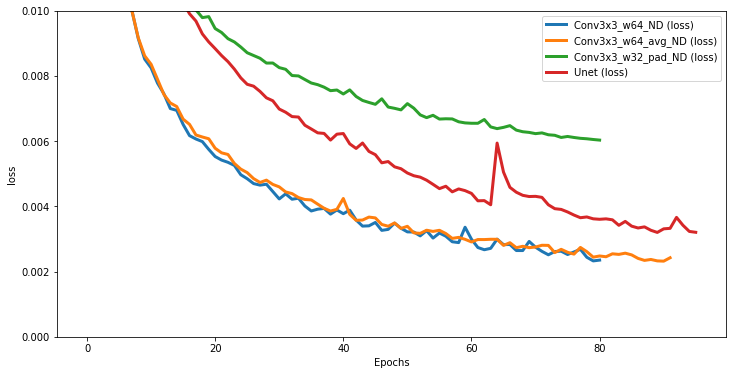

In [ ]:
plot_perf(hists,['Conv3x3_w64_ND','Conv3x3_w64_avg_ND','Conv3x3_w32_pad_ND','Unet'],['loss'])
plt.ylim((0,0.01))

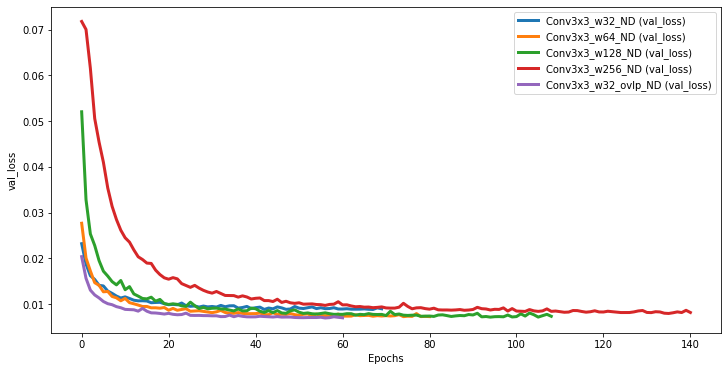

In [ ]:
plot_perf(hists,['Conv3x3_w32_ND','Conv3x3_w64_ND','Conv3x3_w128_ND','Conv3x3_w256_ND','Conv3x3_w32_ovlp_ND'],['val_loss'])

In [ ]:
#Saving Models

#v1 = orig
#v2 = smaller, removed one encoder and one decoder layer
# Currently prefer conv3x3_v2 and Unet_v2_SGD - Unet overfits on real data

# SGD = using lr = 0.001, converges slightly slower

# modelUnetMSE.save('./models/UnetMSE_16filt')
# modelUnetMSE.save('./models/UnetMSE_8filt')
# modelANN_wind.save('./models/ANN_wind_4')
# modelANN_trc.save('./models/ANN_trc_4')

# modelANN_trc_SGD.save('./models/ANN_trc_SGD_p')

# modelConv3x3.save('./models/UpscConv3x3')
# modelConv3x3_v2.save('./models/UpscConv3x3_v2')
# modelConv3x3_SGD.save('./models/UpscConv3x3_SGD')
# modelConv3x3_v2_HF.save('./models/UpscConv3x3_v2_HF')
# modelConv3x3_v2_dr_HF.save('./models/UpscConv3x3_v2_dr_HF')

# modelConvUnet.save('./models/Unet_v1')
# modelConvUnet_v2.save('./models/Unet_v2')
# modelConvUnet_v2_SGD.save('./models/Unet_v2_SGD')
# modelConvUnet_v3_SGD.save('./models/Unet_v3_SGD')

# ANN_trc.save('./models/new_data/ANN')
# Conv3x3.save('./models/new_data/Conv3x3')
# Unet.save('./models/new_data/Unet')

# Conv3x3.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32')
# Conv3x3_w64.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w64')
# Conv3x3_w128.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w128')
# Conv3x3_w256.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w256')


# Conv3x3_w32_avg.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_avg')
# Conv3x3_w64_avg.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w64_avg')
# Conv3x3_w128_avg.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w128_avg')
# Conv3x3_w256_avg.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w256_avg')

# Conv3x3_w32_ovlp.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_ovlp')

# Conv3x3_w32_pad.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_pad')

# Conv3x3_w32_v2.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_v2')
Unet.save('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Unet_v2')



INFO:tensorflow:Assets written to: /content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Unet_v2/assets


In [ ]:
from tensorflow.keras.models import load_model
# modelANN_trc = load_model('./models/ANN_trc_4')
# modelANN_wind = load_model('./models/ANN_wind_4')
# modelConv3x3_v1 = load_model('./models/UpscConv3x3_v2/')
# modelConv3x3 = load_model('./models/UpscConv3x3')
# modelConv3x3_v2 = load_model('./models/UpscConv3x3_v2')
# modelConv3x3_SGD = load_model('./models/UpscConv3x3_SGD')
# modelConvUnet = load_model('./models/Unet_v1')
# modelConvUnet_v2 = load_model('./models/Unet_v2')
# modelConvUnet_v2_SGD = load_model('./models/Unet_v2_SGD')
# modelConv3x3_v2_HF = load_model('./models/UpscConv3x3_v2_HF')
# modelConv3x3_v2_dr_HF = load_model('./models/UpscConv3x3_v2_dr_HF')

Conv3x3_w32 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32')
Conv3x3_w64 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w64')
Conv3x3_w128 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w128')
Conv3x3_w256 = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w256')

Conv3x3_w32_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_avg')
Conv3x3_w64_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w64_avg')
Conv3x3_w128_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w128_avg')
Conv3x3_w256_avg = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w256_avg')

Conv3x3_w32_ovlp = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Conv3x3_w32_ovlp')

Unet = load_model('/content/drive/MyDrive/Programming/ML/AutoEncoderImageDenoise/models/new_data/Unet_v2')

In [ ]:
def pred_resh(data,output_size,num_wind,wind_size):

    # Reshaping predictions
    data_resh= data.reshape(int(data.shape[0]/num_wind),num_wind,wind_size,wind_size)

    img = []

    for iImg in range(data_resh.shape[0]):
        img.append(windows2img(data_resh[iImg],output_size,output_size))

    img = np.array(img)


    return img

In [ ]:
def crop(data,win_size):
  cropped_data = []
  half = int(win_size/2)
  for i in range(data.shape[0]):
    cropped_data.append(data[i,half:win_size+half,half:win_size+half])

  return np.array(cropped_data)

In [ ]:
cropimg = crop()

In [ ]:
# Predicting

# pred = modelUnet.predict(NS_test)
# pred2 = modelUnet.predict(ns_test)
# predmse = modelUnetMSE.predict(NS_test_nosc)
# predmse3 = modelUnetMSE.predict(NS_test_nosc)

# pred_upsc = modelUpSc.predict(ns_test)
# pred_nosc = modelUnetNoSc.predict(NS_test_nosc)

# predANN_trc = modelANN_trc_v1.predict(NS_test_trc_resh)
# predANN_trc = modelANN_trc.predict(NS_test_trc_resh)
# predANN_trc_SGD = modelANN_trc_SGD.predict(NS_test_trc_resh)


# predANN_wind_v1 = modelANN_wind_v1.predict(NS_test_wind_resh)
# predANN_wind = modelANN_wind.predict(NS_test_wind_resh)

# predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
# predConv_wind_4x4 = modelConv4x4.predict(NS_test_conv_resh)

# predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
# predConv_wind_3x3_v2 = modelConv3x3_v2.predict(NS_test_conv_resh)
# predConv_wind_3x3_v2_HF = modelConv3x3_v2_HF.predict(NS_test_conv_resh)
# predConv_wind_3x3_v2_dr_HF = modelConv3x3_v2_dr_HF.predict(NS_test_conv_resh)

# predConvUnet = modelConvUnet.predict(NS_test_conv_resh)
# predConvUnet_v2 = modelConvUnet_v2.predict(NS_test_conv_resh)
# predConvUnet_v2_SGD = modelConvUnet_v2_SGD.predict(NS_test_conv_resh)
# predConvUnet_v3_SGD = modelConvUnet_v3_SGD.predict(NS_test_conv_resh)

# predANN_trc = ANN_trc.predict(NS_test_trc_resh).reshape(NS_test.shape)
# predConv3x3 = Conv3x3.predict(NS_test_conv_resh)
# predUnet = Unet.predict(NS_test_conv_resh)


predConv3x3_w32 = Conv3x3_w32.predict(NS_test_conv_resh_w32)
# predConv3x3_w64 = Conv3x3_w64.predict(NS_test_conv_resh_w64)
# predConv3x3_w128 = Conv3x3_w128.predict(NS_test_conv_resh_w128)
# predConv3x3_w256 = Conv3x3_w256.predict(NS_test_conv_resh_w256)

predConv3x3_ovlp_w32 = Conv3x3_w32_ovlp.predict(NS_test_conv_resh_w32)


predConv3x3_w32_avg = Conv3x3_w32_avg.predict(NS_test_conv_resh_w32)

# predConv3x3_w32_pad = crop(Conv3x3_w32_pad.predict(NS_test_conv_resh_w32_pad),win_size=32)

predUnet_w32 = Unet.predict(NS_test_conv_resh_w32)


# predConv3x3_w64_avg = Conv3x3_w64_avg.predict(NS_test_conv_resh_w64)
# predConv3x3_w128_avg = Conv3x3_w128_avg.predict(NS_test_conv_resh_w128)
# predConv3x3_w256_avg = Conv3x3_w256_avg.predict(NS_test_conv_resh_w256)

In [16]:
# decodedimg_conv3x3 = pred_resh(predConv_wind_3x3,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv3x3_v2 = pred_resh(predConv_wind_3x3_v2,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv3x3_v2_HF = pred_resh(predConv_wind_3x3_v2_HF,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv3x3_v2_dr_HF = pred_resh(predConv_wind_3x3_v2_dr_HF,output_size=256,num_wind=64,wind_size=32)


# decodedimg_convUnet = pred_resh(predConvUnet,output_size=256,num_wind=64,wind_size=32)
# decodedimg_convUnet_v2 = pred_resh(predConvUnet_v2,output_size=256,num_wind=64,wind_size=32)
# decodedimg_convUnet_v2_SGD = pred_resh(predConvUnet_v2_SGD,output_size=256,num_wind=64,wind_size=32)

# decodedimg_convUnet_v3_SGD = pred_resh(predConvUnet_v3_SGD,output_size=256,num_wind=64,wind_size=32)

# predConv3x3_img = pred_resh(predConv3x3,output_size=256,num_wind=64,wind_size=32)
# predUnet_img = pred_resh(predUnet,output_size=256,num_wind=64,wind_size=32)


predimg_w32 = pred_resh(predConv3x3_w32,output_size=256,num_wind=64,wind_size=32)
# predimg_w64 = pred_resh(predConv3x3_w64,output_size=256,num_wind=16,wind_size=64)
# predimg_w128 = pred_resh(predConv3x3_w128,output_size=256,num_wind=4,wind_size=128)

predimg_w32_avg = pred_resh(predConv3x3_w32_avg,output_size=256,num_wind=64,wind_size=32)
# predimg_w64_avg = pred_resh(predConv3x3_w64_avg,output_size=256,num_wind=16,wind_size=64)
# predimg_w128_avg = pred_resh(predConv3x3_w128_avg,output_size=256,num_wind=4,wind_size=128)
predimg_w32_ovlp = pred_resh(predConv3x3_ovlp_w32,output_size=256,num_wind=64,wind_size=32)

# predimg_w32_pad = pred_resh(predConv3x3_w32_pad,output_size=256,num_wind=64,wind_size=32)

predimg_Unet_w32 = pred_resh(predUnet_w32,output_size=256,num_wind=64,wind_size=32)


# decodedimg_ANNwind = pred_resh(predANN_wind,output_size=256,num_wind=256,wind_size=16)

In [ ]:
# predimg_w32_ovlp = []
# predConv3x3_ovlp_w32 = predConv3x3_ovlp_w32.reshape(NS_test_conv_ovlp_w32.shape)
# for i in range(NS_test_conv_ovlp_w32.shape[0]):
#   predimg_w32_ovlp.append(unpatchify(predConv3x3_ovlp_w32[i],(256,256)))

# predimg_w32_ovlp = np.array(predimg_w32_ovlp)

In [17]:
orig_noisy = NS_test.reshape(198,256,256)
orig_clean = S_test.reshape(198,256,256)

In [29]:
diff_w32 = orig_noisy-predimg_w32
# diff_w64 = orig_clean-predimg_w64
# diff_w128 = orig_clean-predimg_w128
# diff_w256 = orig_clean-predConv3x3_w256.reshape(198,256,256)

diff_w32_avg = orig_noisy-predimg_w32_avg

diff_w32_ovlp = orig_noisy-predimg_w32_ovlp

diff_w32_Unet = orig_noisy-predimg_Unet_w32

# diff_w64_avg = orig_clean-predimg_w64_avg
# diff_w128_avg = orig_clean-predimg_w128_avg
# diff_w256_avg = orig_clean-predConv3x3_w256_avg.reshape(198,256,256)

In [31]:
num =50

<Figure size 1080x720 with 0 Axes>

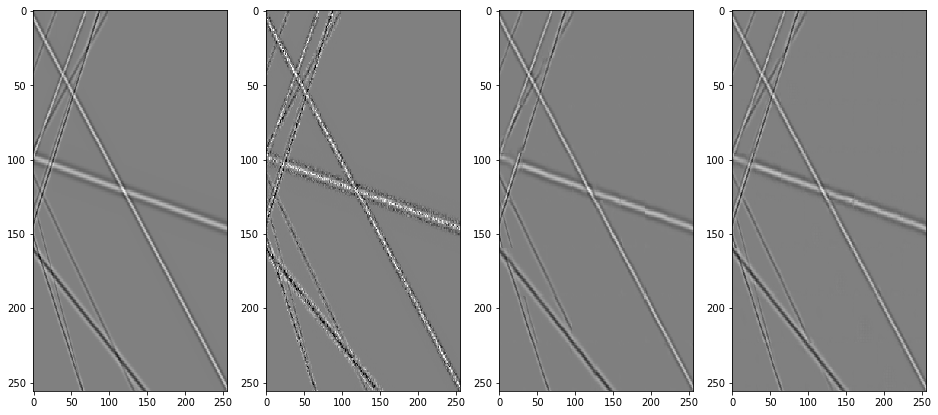

In [32]:
plt.figure(figsize=(15,10))
PlotSeis([orig_clean,orig_noisy,predimg_w32,predimg_Unet_w32],num=num)

<Figure size 1080x720 with 0 Axes>

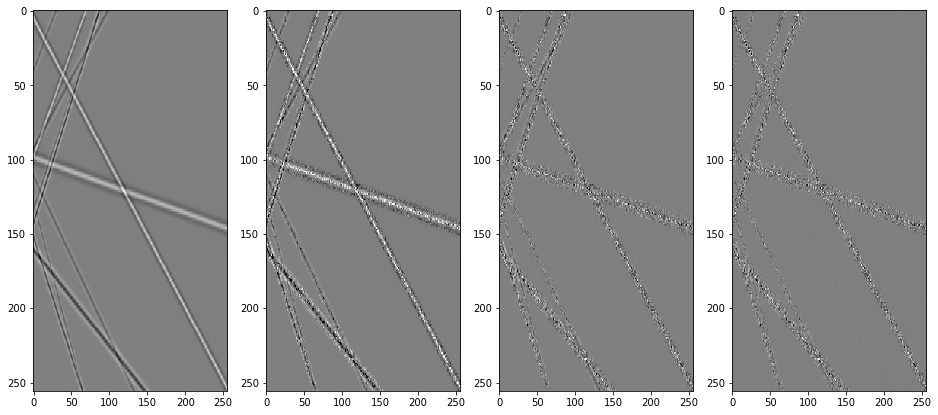

In [33]:
plt.figure(figsize=(15,10))
PlotSeis([orig_clean,orig_noisy,diff_w32,diff_w32_Unet],num=num)